<a href="https://colab.research.google.com/github/nidhi-158/Meal-Plan/blob/main/meal_plan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Only SVM

         recipe_name                          ingredients  calories  protein  \
0       Caesar Salad  Romaine Lettuce, Croutons, Parmesan       180        7   
1    Margarita Pizza      Dough, Tomato Sauce, Mozzarella       300       15   
2  Vegetable Lasagna      Zucchini, Tomato Sauce, Ricotta       350       20   

   carbs  fat  price($)  
0      8   12       4.5  
1     40   10       8.0  
2     45   15       6.5  


Index(['recipe_name', 'ingredients', 'calories', 'protein', 'carbs', 'fat',
       'price($)'],
      dtype='object')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   recipe_name  100 non-null    object 
 1   ingredients  100 non-null    object 
 2   calories     100 non-null    int64  
 3   protein      100 non-null    int64  
 4   carbs        100 non-null    int64  
 5   fat          100 non-null    int64  
 6   price($) 

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


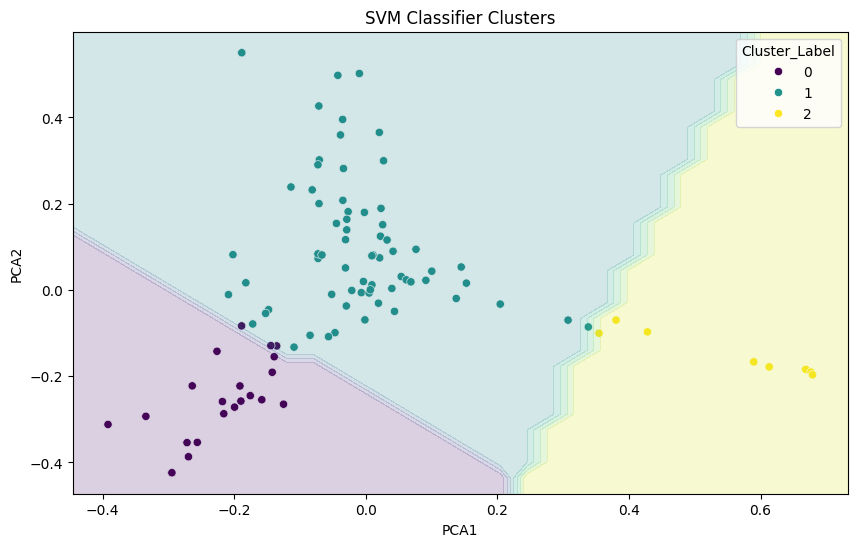

Classification Report (SVM):
              precision    recall  f1-score   support

           0       1.00      0.62      0.77         8
           1       0.87      1.00      0.93        20
           2       1.00      1.00      1.00         2

    accuracy                           0.90        30
   macro avg       0.96      0.88      0.90        30
weighted avg       0.91      0.90      0.89        30



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

# Load data
df = pd.read_excel("/content/recipees.xlsx")
print(df.head(3))
print("\n")
print(df.columns)
print("\n")

# Basic data checks
print(df.info())
print("\n")
print(df.describe())
print(f"Missing values:\n{df.isnull().sum()}")
print(f"Duplicated rows: {df.duplicated().sum()}")

# Check for missing columns
required_columns = ['ingredients', 'calories', 'protein', 'carbs', 'fat', 'price($)']
missing_columns = [col for col in required_columns if col not in df.columns]
if missing_columns:
    print(f"Missing columns: {missing_columns}")

# Data Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[['calories', 'protein', 'carbs', 'fat', 'price($)']])

# Load NLTK resources
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

# Preprocess the ingredients
def preprocess(text):
    tokens = nltk.word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalnum()]
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    tokens = [WordNetLemmatizer().lemmatize(word) for word in tokens]
    return ' '.join(tokens)

df['cleaned_ingredients'] = df['ingredients'].apply(preprocess)

# Convert text to numeric format
vectorizer = TfidfVectorizer()
X_text = vectorizer.fit_transform(df['cleaned_ingredients'])
print(X_text.shape)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
reduced_X = pca.fit_transform(X_text.toarray())
df['PCA1'] = reduced_X[:, 0]
df['PCA2'] = reduced_X[:, 1]
print(reduced_X.shape)

# K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(reduced_X)
df['KMeans_Cluster'] = kmeans_labels

# Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=3)
agg_labels = agg_clustering.fit_predict(reduced_X)
df['Agglomerative_Cluster'] = agg_labels

# Prepare data for classification
X_train, X_test, y_train, y_test = train_test_split(reduced_X, kmeans_labels, test_size=0.3, random_state=42)

# SVM Classification
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)
svm_predictions = svm_model.predict(X_test)
svm_score = svm_model.score(X_test, y_test)
print(f"SVM Classification Accuracy: {svm_score}")

# Add SVM predictions to the DataFrame
df['Cluster_Label'] = svm_model.predict(reduced_X)

# Plotting the SVM decision boundaries
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster_Label', data=df, palette='viridis')
plt.title('SVM Classifier Clusters')

# Plot decision boundaries
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 30), np.linspace(ylim[0], ylim[1], 30))
Z = svm_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

ax.contourf(xx, yy, Z, alpha=0.2, cmap='viridis')
plt.show()

# Save the DataFrame with cluster labels to a new CSV file
df.to_csv('/content/recipees_with_all_clusters.csv', index=False)

classification_report_svm = classification_report(y_test, svm_predictions)
print("Classification Report (SVM):")
print(classification_report_svm)

In [ ]:
df.columns

Index(['recipe_name', 'ingredients', 'calories', 'protein', 'carbs', 'fat',
       'price($)', 'cleaned_ingredients', 'PCA1', 'PCA2', 'KMeans_Cluster',
       'Agglomerative_Cluster', 'Cluster_Label'],
      dtype='object')

In [ ]:
df.protein.unique()

array([ 7, 15, 20, 25,  4,  5, 30, 10,  3,  6, 12,  8,  2, 35,  1])

In [ ]:
import pickle
# Save the model and scaler to .sav files
with open('svm_model.sav', 'wb') as model_file:
    pickle.dump(svm_model, model_file)
with open('scaler_model11.sav', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)

print("Model and scaler saved successfully.")

Model and scaler saved successfully.
